In [113]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import missingno as msno
from sklearn.compose import ColumnTransformer
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns


In [114]:
# !pip install missingno

### Data Exploration

In [115]:
df = pd.read_csv("houses.csv").reindex()
df.head()

index                                              title  final_price  \
0      0  1303 - 38 Grenville St, Toronto (C4461599) | Z...       855000   
1      1          2 Cabot Crt, Toronto (W4502992) | Zoocasa       885000   
2      2  1504 - 30 Roehampton Ave, Toronto (C4511330) |...       550000   
3      3  514 - 65 East Liberty St, Toronto (C4515763) |...       665000   
4      4        61 Twelfth St, Toronto (W4519375) | Zoocasa       825513   

   list_price    bedrooms  bathrooms   sqft  parking  \
0      870000  2 + 1 beds          2  850.0        1   
1      898000      3 beds          2    NaN        6   
2      549900      1 beds          1  550.0        0   
3      600000  1 + 1 beds          1  650.0        1   
4      839000      2 beds          2    NaN        1   

                                         description       mls           type  \
0  Luxurious And Spacious Murano Tower. 2+1, 2 Ba...  C4461599      Condo Apt   
1  Fantastic Opportunity To Live Within The Histo...  W4502992  Semi-Detached   
2  Bright Sunfilled Spacious 1 Bdr Unit; Floor To...  C4511330      Condo Apt   
3  Rare Loft-Like Condo In Liberty Village W/ 18'...  C4515763      Condo Apt   
4  Location! Location! Location. Your Cottage In ...  W4519375       Detached   

                                           full_link  \
0  https://www.zoocasa.com/toronto-on-real-estate...   
1  https://www.zoocasa.com/toronto-on-real-estate...   
2  https://www.zoocasa.com/toronto-on-real-estate...   
3  https://www.zoocasa.com/toronto-on-real-estate...   
4  https://www.zoocasa.com/toronto-on-real-estate...   

                                     full_address        lat       long  \
0      38 Grenville St, Toronto , Ontario, Canada  43.661896 -79.385748   
1          2 Cabot Crt, Toronto , Ontario, Canada  43.646982 -79.530356   
2    30 Roehampton Ave, Toronto , Ontario, Canada  43.708472 -79.397498   
3   65 East Liberty St, Toronto , Ontario, Canada  43.638399 -79.414448   
4        61 Twelfth St, Toronto , Ontario, Canada  43.597096 -79.509612   

                city_district  mean_district_income  district_code  
0         Bay Street Corridor                 56526             76  
1  Islington-City Centre West                 52787             14  
2         Mount Pleasant West                 57039            104  
3                     Niagara                 70623             82  
4                 New Toronto                 44101             18

In [116]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15234 entries, 0 to 15233
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 15234 non-null  int64  
 1   title                 15234 non-null  object 
 2   final_price           15234 non-null  int64  
 3   list_price            15234 non-null  int64  
 4   bedrooms              15234 non-null  object 
 5   bathrooms             15234 non-null  int64  
 6   sqft                  10713 non-null  float64
 7   parking               15234 non-null  int64  
 8   description           15185 non-null  object 
 9   mls                   15234 non-null  object 
 10  type                  15234 non-null  object 
 11  full_link             15234 non-null  object 
 12  full_address          15234 non-null  object 
 13  lat                   15234 non-null  float64
 14  long                  15234 non-null  float64
 15  city_district      

Index(['index', 'title', 'final_price', 'list_price', 'bedrooms', 'bathrooms',
       'sqft', 'parking', 'description', 'mls', 'type', 'full_link',
       'full_address', 'lat', 'long', 'city_district', 'mean_district_income',
       'district_code'],
      dtype='object')

In [117]:
df.bedrooms

0        2 + 1 beds
1            3 beds
2            1 beds
3        1 + 1 beds
4            2 beds
            ...    
15229        2 beds
15230        5 beds
15231        3 beds
15232        1 beds
15233    2 + 1 beds
Name: bedrooms, Length: 15234, dtype: object

In [118]:
df.drop(['title', 'list_price', 'mls'], axis=1, inplace=True)

### Pre-Processing for Baseline Model

In [119]:
df['bedrooms'] = df['bedrooms'].str.replace(' beds', '')
df['bedrooms'] = df['bedrooms'].str.replace(' +', '')

C:\Users\bevli\AppData\Local\Temp/ipykernel_2836/1930054018.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['bedrooms'] = df['bedrooms'].str.replace(' +', '')


In [120]:
#Splitting bedrooms into bedroom plus den if item contains '+'
bedroom_den = df['bedrooms'].tolist()

bedroom = []
den = [] 

for i in bedroom_den:
    if '+' in i:
        x = i.split('+')
        bedroom.append(x[0])
        den.append(x[1])
    else:
        bedroom.append(i)
        den.append(0)
        

In [121]:
print (len(bedroom), len(den))

15234 15234


In [122]:
#Adding bedroom and den columns to DataFrame

df_1 = pd.concat([pd.Series(bedroom,name='bedroom'),pd.Series(den,name='den')], axis=1).reindex()

# Merge two Dataframes on index of both the dataframes
df = df.merge(df_1, left_index = True, right_index=True)
df.drop(columns = ['bedrooms'], inplace = True, axis = 1)

In [123]:
#Converting bedroom and den object type to int

df[['bedroom','den']] = df[['bedroom','den']].astype('int64')

In [124]:
df.drop('index',inplace = True,axis =1)

### Modeling to Predict missing Square Footage values

In [125]:
df_repl = df.copy(deep = True)

In [126]:
df_repl.drop(['description','full_link','full_address', 'lat', 'long','district_code', 'mean_district_income' ],axis = 1, inplace = True)

final_price       0.000000
bathrooms         0.000000
sqft             29.677038
parking           0.000000
type              0.000000
city_district     0.000000
bedroom           0.000000
den               0.000000
dtype: float64


<AxesSubplot:>

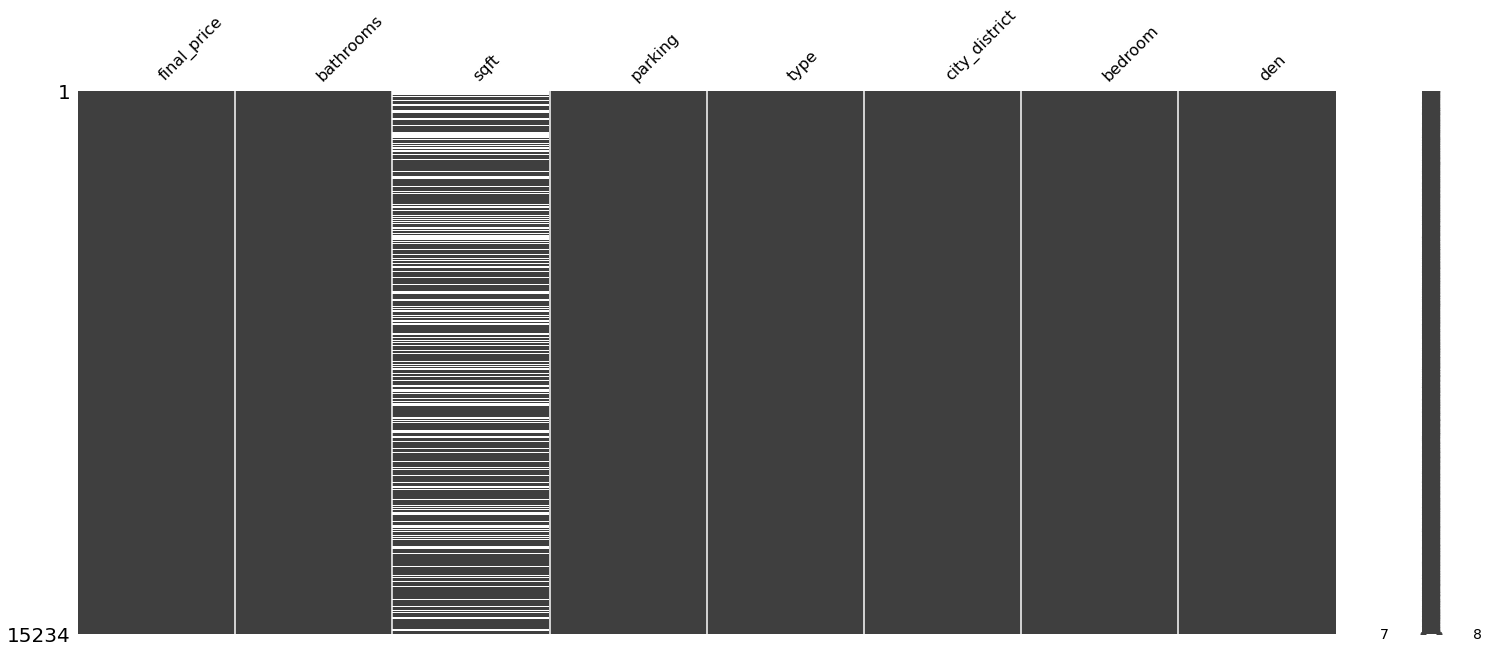

In [127]:
mis_value_percent = 100 * df_repl.isnull().sum() / len(df_repl)
print(mis_value_percent)

msno.matrix(df_repl)

Condo Apt  -  7572
Number of null values -  0


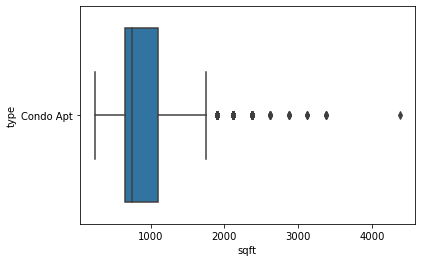

Semi-Detached  -  1435
Number of null values -  1067


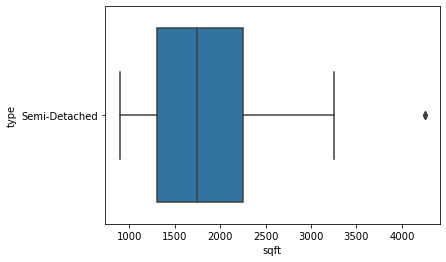

Detached  -  4361
Number of null values -  3144


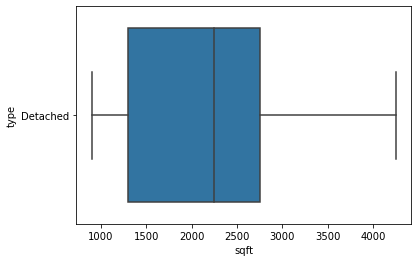

Condo Townhouse  -  1062
Number of null values -  0


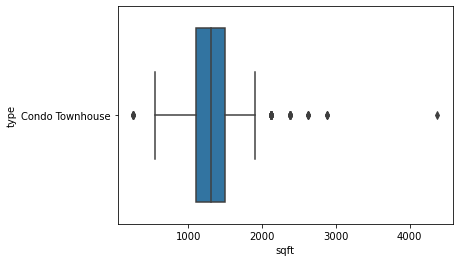

Plex  -  70
Number of null values -  43


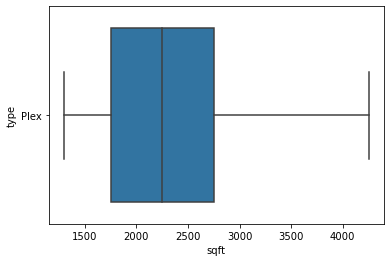

Att/Row/Twnhouse  -  467
Number of null values -  245


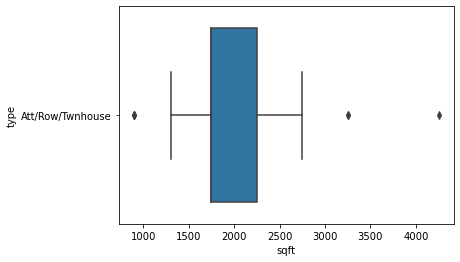

Comm Element Condo  -  181
Number of null values -  0


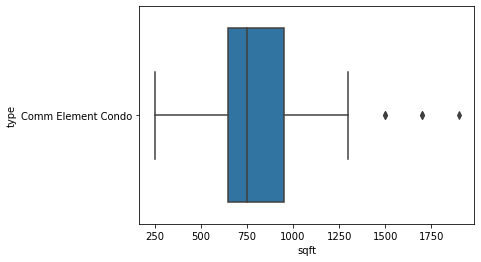

Link  -  27
Number of null values -  16


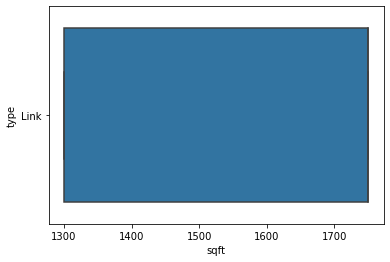

Co-Ownership Apt  -  27
Number of null values -  0


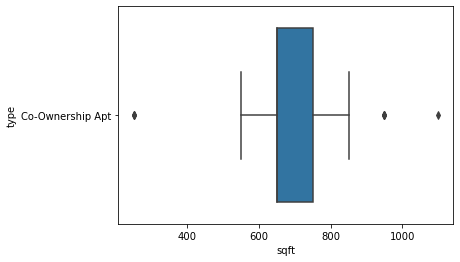

Co-Op Apt  -  24
Number of null values -  0


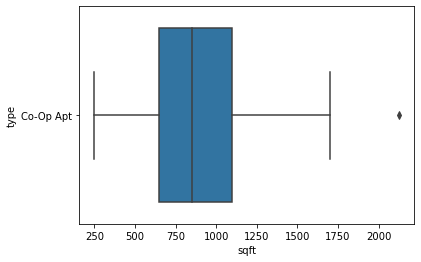

Store W/Apt/Offc  -  8
Number of null values -  6


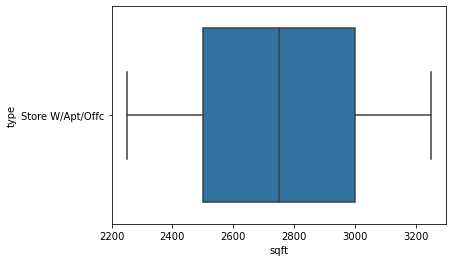

In [128]:
#checking distribution of square footage with respect to various variables

for i in df_repl.type.unique():
    
    print(i," - ", len(df_repl[df_repl['type'] == i]))
    print('Number of null values - ',df_repl[df_repl['type']==i].sqft.isnull().sum())
    sns.boxplot(y = df_repl[df_repl['type'] == i]['type'], x = df_repl.sqft)
    plt.show()


#### *** Since majority of the NaN values are present for the detached and semi detached type of homes, it is not practical to replace NaN values using metric such as mean or median. An XGBRegressor will be used to predict the missing Square Footage Values in order to make a Baseline model and hence, commence with new feature engineering and model optimization.

#### With all House types

In [139]:
#Train test split for prediction using all house types

test_data = df_repl[df_repl['sqft'].isnull()]
df_repl.dropna(inplace = True)

X_train = df_repl.drop('sqft',axis = 1)
X_test = test_data.drop('sqft',axis = 1)
y_train = df_repl['sqft']

In [161]:
import xgboost
from sklearn.preprocessing import OneHotEncoder

scaler = MinMaxScaler()

In [132]:
#Column Transformer and Creating Pipeline

preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), ['type','city_district']),
    ('sclaer', MinMaxScaler(), ['final_price', 'bathrooms', 'parking', 'bedroom', 'den'])])

from xgboost import XGBRegressor

pipeline = Pipeline(steps = [('features',preprocessor),
                            ('xgbregressor',XGBRegressor())])

In [133]:
#Fit the Pipeline and predict square foot values using all houses

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

XGBoostError: [23:35:39] C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/data/data.cc:481: Check failed: this->labels.Size() % this->num_row_ == 0 (5819 vs. 0) : Incorrect size for labels.

In [50]:
#preparing X_test and X_train for concatenation
X_test['sqft'] = y_pred
X_train['sqft'] = y_train

In [51]:
df_merged = pd.concat([X_train, X_test], ignore_index=False, sort=False)
df_merged

final_price  bathrooms  parking              type  \
0           855000          2        1         Condo Apt   
2           550000          1        0         Condo Apt   
3           665000          1        1         Condo Apt   
5           368000          1        1         Condo Apt   
6          2700000          5        2          Detached   
...            ...        ...      ...               ...   
15218      1595000          3        4          Detached   
15223      1222500          3        6          Detached   
15226      1050000          4        4          Detached   
15231       681000          3        1  Att/Row/Twnhouse   
15233       530000          2        4          Detached   

                city_district  bedroom  den         sqft  
0         Bay Street Corridor        2    1   850.000000  
2         Mount Pleasant West        1    0   550.000000  
3                     Niagara        1    1   650.000000  
5                 New Toronto        0    0   250.000000  
6         Lawrence Park South        4    0  2750.000000  
...                       ...      ...  ...          ...  
15218      Princess-Rosethorn        3    1  2399.219727  
15223          Bathurst Manor        3    1  1794.945190  
15226              L'Amoreaux        5    2  2892.250244  
15231  Centennial Scarborough        3    0  1695.414795  
15233   Birchcliffe-Cliffside        2    1  1086.917725  

[15234 rows x 8 columns]

In [52]:
## Merging newly predicted square footage values to orginal dataframe

# merge
dfx = pd.merge(df, df_merged[['sqft']], left_index = True,
    right_index = True)

# coalesce sqft column to get first non NA value
dfx['sqft'] = dfx['sqft_x'].combine_first(dfx['sqft_y']).astype('int64')

# remove the cols
dfx = dfx.drop(['sqft_x', 'sqft_y'], 1)

C:\Users\bevli\AppData\Local\Temp/ipykernel_2836/2869888798.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dfx = dfx.drop(['sqft_x', 'sqft_y'], 1)


In [60]:
dfx

final_price  bathrooms  parking  \
0           855000          2        1   
1           885000          2        6   
2           550000          1        0   
3           665000          1        1   
4           825513          2        1   
...            ...        ...      ...   
15229       785000          2        1   
15230      1025000          5        2   
15231       681000          3        1   
15232       590000          1        0   
15233       530000          2        4   

                                             description              type  \
0      Luxurious And Spacious Murano Tower. 2+1, 2 Ba...         Condo Apt   
1      Fantastic Opportunity To Live Within The Histo...     Semi-Detached   
2      Bright Sunfilled Spacious 1 Bdr Unit; Floor To...         Condo Apt   
3      Rare Loft-Like Condo In Liberty Village W/ 18'...         Condo Apt   
4      Location! Location! Location. Your Cottage In ...          Detached   
...                                                  ...               ...   
15229  Tableau Condo - Right In The Middle Of The Ent...         Condo Apt   
15230  New Years Special. Brand New House. Beautiful ...          Detached   
15231  Absolutely Beautiful **Freehold ** **End Unit*...  Att/Row/Twnhouse   
15232  One Year New Luxury Condo Built By Menkes. Hig...         Condo Apt   
15233  Great Builder Lot In Birchcliff Village. Can B...          Detached   

                                               full_link  \
0      https://www.zoocasa.com/toronto-on-real-estate...   
1      https://www.zoocasa.com/toronto-on-real-estate...   
2      https://www.zoocasa.com/toronto-on-real-estate...   
3      https://www.zoocasa.com/toronto-on-real-estate...   
4      https://www.zoocasa.com/toronto-on-real-estate...   
...                                                  ...   
15229  https://www.zoocasa.com/toronto-on-real-estate...   
15230  https://www.zoocasa.com/toronto-on-real-estate...   
15231  https://www.zoocasa.com/toronto-on-real-estate...   
15232  https://www.zoocasa.com/toronto-on-real-estate...   
15233  https://www.zoocasa.com/toronto-on-real-estate...   

                                         full_address        lat       long  \
0          38 Grenville St, Toronto , Ontario, Canada  43.661896 -79.385748   
1              2 Cabot Crt, Toronto , Ontario, Canada  43.646982 -79.530356   
2        30 Roehampton Ave, Toronto , Ontario, Canada  43.708472 -79.397498   
3       65 East Liberty St, Toronto , Ontario, Canada  43.638399 -79.414448   
4            61 Twelfth St, Toronto , Ontario, Canada  43.597096 -79.509612   
...                                               ...        ...        ...   
15229         125 Peter St, Toronto , Ontario, Canada  43.648317 -79.393065   
15230      179 Raleigh Ave, Toronto , Ontario, Canada  43.706338 -79.262789   
15231    68 Stagecoach Cir, Toronto , Ontario, Canada  43.788258 -79.160342   
15232        365 Church St, Toronto , Ontario, Canada  43.660846 -79.378756   
15233        43 Kalmar Ave, Toronto , Ontario, Canada  43.691296 -79.268417   

                           city_district  mean_district_income  district_code  \
0                    Bay Street Corridor                 56526             76   
1             Islington-City Centre West                 52787             14   
2                    Mount Pleasant West                 57039            104   
3                                Niagara                 70623             82   
4                            New Toronto                 44101             18   
...                                  ...                   ...            ...   
15229  Waterfront Communities-The Island                 70600             77   
15230                Clairlea-Birchmount                 36232            120   
15231             Centennial Scarborough                 54045            133   
15232              Church-Yonge Corridor                 53583             75   
1523

#### Without any condominium homes

In [176]:
df_repl_2 = df.copy(deep = True)
df_repl_2.drop(['description','full_link','full_address', 'lat', 'long','district_code', 'mean_district_income','city_district' ],axis = 1, inplace = True)

In [177]:
#Train test split for prediction using all house types 
#containing majority of the nan values

test_data2 = df_repl_2[df_repl_2['sqft'].isnull()]
df_repl_2.dropna(inplace = True)


X_train2 = df_repl_2[df_repl_2['type'].isin(['Detached','Plex','Semi-Detached','Att/Row/Twnhouse','Link','Store W/Apt/Offc'])].drop('sqft',axis = 1)
X_test2 = test_data2.drop('sqft',axis = 1)
y_train2 = df_repl_2[df_repl_2['type'].isin(['Detached','Plex','Semi-Detached','Att/Row/Twnhouse','Link','Store W/Apt/Offc'])]['sqft']

X_train_merge = df_repl_2[df_repl_2['type'].isin(['Condo Apt',  'Condo Townhouse',  'Comm Element Condo', 'Co-Ownership Apt', 'Co-Op Apt'])]


In [178]:
import xgboost
from sklearn.preprocessing import OneHotEncoder

scaler = MinMaxScaler()

In [179]:
#Column Transformer and Creating Pipeline 2

preprocessor2 = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), ['type']),
    ('sclaer', MinMaxScaler(), ['final_price', 'bathrooms', 'parking', 'bedroom', 'den'])])

from xgboost import XGBRegressor

pipeline2 = Pipeline(steps = [('features',preprocessor2),
                            ('xgbregressor',XGBRegressor())])

In [180]:
#Fit the Pipeline and predict square foot values using nan houses

pipeline2.fit(X_train2, y_train2)
y_pred2 = pipeline2.predict(X_test2)

In [182]:
#preparing X_test and X_train for concatenation using nan houses
X_test2['sqft'] = y_pred2
X_train2['sqft'] = y_train2

In [183]:
df_merged2 = pd.concat([X_train2, X_test2, X_train_merge], ignore_index=False, sort=False)
df_merged2

final_price  bathrooms  parking           type  bedroom  den    sqft
6          2700000          5        2       Detached        4    0  2750.0
8           975000          2        1           Plex        2    0  1300.0
11         1530000          5        4       Detached        4    2  3250.0
12         2250000          4        2  Semi-Detached        3    1  2750.0
13         2100000          3        2       Detached        4    0  1750.0
...            ...        ...      ...            ...      ...  ...     ...
15225       630000          2        1      Condo Apt        2    0  1100.0
15227       565000          1        1      Condo Apt        1    1   750.0
15228       670000          2        1      Condo Apt        2    1   850.0
15229       785000          2        1      Condo Apt        2    0   750.0
15232       590000          1        0      Condo Apt        1    0   550.0

[15234 rows x 7 columns]

In [184]:
## Merging newly predicted square footage values to orginal dataframe

# merge
dfx2 = pd.merge(df, df_merged2[['sqft']], left_index = True,
    right_index = True)

# coalesce sqft column to get first non NA value
dfx2['sqft'] = dfx2['sqft_x'].combine_first(dfx2['sqft_y']).astype('int64')

# remove the cols
dfx2 = dfx2.drop(['sqft_x', 'sqft_y'], 1)

C:\Users\bevli\AppData\Local\Temp/ipykernel_2836/163500469.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dfx2 = dfx2.drop(['sqft_x', 'sqft_y'], 1)


In [185]:
dfx2

final_price  bathrooms  parking  \
0           855000          2        1   
1           885000          2        6   
2           550000          1        0   
3           665000          1        1   
4           825513          2        1   
...            ...        ...      ...   
15229       785000          2        1   
15230      1025000          5        2   
15231       681000          3        1   
15232       590000          1        0   
15233       530000          2        4   

                                             description              type  \
0      Luxurious And Spacious Murano Tower. 2+1, 2 Ba...         Condo Apt   
1      Fantastic Opportunity To Live Within The Histo...     Semi-Detached   
2      Bright Sunfilled Spacious 1 Bdr Unit; Floor To...         Condo Apt   
3      Rare Loft-Like Condo In Liberty Village W/ 18'...         Condo Apt   
4      Location! Location! Location. Your Cottage In ...          Detached   
...                                                  ...               ...   
15229  Tableau Condo - Right In The Middle Of The Ent...         Condo Apt   
15230  New Years Special. Brand New House. Beautiful ...          Detached   
15231  Absolutely Beautiful **Freehold ** **End Unit*...  Att/Row/Twnhouse   
15232  One Year New Luxury Condo Built By Menkes. Hig...         Condo Apt   
15233  Great Builder Lot In Birchcliff Village. Can B...          Detached   

                                               full_link  \
0      https://www.zoocasa.com/toronto-on-real-estate...   
1      https://www.zoocasa.com/toronto-on-real-estate...   
2      https://www.zoocasa.com/toronto-on-real-estate...   
3      https://www.zoocasa.com/toronto-on-real-estate...   
4      https://www.zoocasa.com/toronto-on-real-estate...   
...                                                  ...   
15229  https://www.zoocasa.com/toronto-on-real-estate...   
15230  https://www.zoocasa.com/toronto-on-real-estate...   
15231  https://www.zoocasa.com/toronto-on-real-estate...   
15232  https://www.zoocasa.com/toronto-on-real-estate...   
15233  https://www.zoocasa.com/toronto-on-real-estate...   

                                         full_address        lat       long  \
0          38 Grenville St, Toronto , Ontario, Canada  43.661896 -79.385748   
1              2 Cabot Crt, Toronto , Ontario, Canada  43.646982 -79.530356   
2        30 Roehampton Ave, Toronto , Ontario, Canada  43.708472 -79.397498   
3       65 East Liberty St, Toronto , Ontario, Canada  43.638399 -79.414448   
4            61 Twelfth St, Toronto , Ontario, Canada  43.597096 -79.509612   
...                                               ...        ...        ...   
15229         125 Peter St, Toronto , Ontario, Canada  43.648317 -79.393065   
15230      179 Raleigh Ave, Toronto , Ontario, Canada  43.706338 -79.262789   
15231    68 Stagecoach Cir, Toronto , Ontario, Canada  43.788258 -79.160342   
15232        365 Church St, Toronto , Ontario, Canada  43.660846 -79.378756   
15233        43 Kalmar Ave, Toronto , Ontario, Canada  43.691296 -79.268417   

                           city_district  mean_district_income  district_code  \
0                    Bay Street Corridor                 56526             76   
1             Islington-City Centre West                 52787             14   
2                    Mount Pleasant West                 57039            104   
3                                Niagara                 70623             82   
4                            New Toronto                 44101             18   
...                                  ...                   ...            ...   
15229  Waterfront Communities-The Island                 70600             77   
15230                Clairlea-Birchmount                 36232            120   
15231             Centennial Scarborough                 54045            133   
15232              Church-Yonge Corridor                 53583             75   
1523

#### Dropping all values

In [201]:
df_repl_3 = df.copy(deep = True)
df_repl_3 = df_repl_3[df_repl_3['sqft'].notna()]
df_repl_3

final_price  bathrooms    sqft  parking  \
0           855000          2   850.0        1   
2           550000          1   550.0        0   
3           665000          1   650.0        1   
5           368000          1   250.0        1   
6          2700000          5  2750.0        2   
...            ...        ...     ...      ...   
15227       565000          1   750.0        1   
15228       670000          2   850.0        1   
15229       785000          2   750.0        1   
15230      1025000          5  3250.0        2   
15232       590000          1   550.0        0   

                                             description       type  \
0      Luxurious And Spacious Murano Tower. 2+1, 2 Ba...  Condo Apt   
2      Bright Sunfilled Spacious 1 Bdr Unit; Floor To...  Condo Apt   
3      Rare Loft-Like Condo In Liberty Village W/ 18'...  Condo Apt   
5      Suite 505 Is An Immaculate Condo With The Most...  Condo Apt   
6      Gorgeous Luxury Custom Built, 4 Bdrm Home On A...   Detached   
...                                                  ...        ...   
15227  1 Bed Rm + Den Condo , 9Ft Ceilings, South Exp...  Condo Apt   
15228  Very Bright Suite With Unobstructed View, Grea...  Condo Apt   
15229  Tableau Condo - Right In The Middle Of The Ent...  Condo Apt   
15230  New Years Special. Brand New House. Beautiful ...   Detached   
15232  One Year New Luxury Condo Built By Menkes. Hig...  Condo Apt   

                                               full_link  \
0      https://www.zoocasa.com/toronto-on-real-estate...   
2      https://www.zoocasa.com/toronto-on-real-estate...   
3      https://www.zoocasa.com/toronto-on-real-estate...   
5      https://www.zoocasa.com/toronto-on-real-estate...   
6      https://www.zoocasa.com/toronto-on-real-estate...   
...                                                  ...   
15227  https://www.zoocasa.com/toronto-on-real-estate...   
15228  https://www.zoocasa.com/toronto-on-real-estate...   
15229  https://www.zoocasa.com/toronto-on-real-estate...   
15230  https://www.zoocasa.com/toronto-on-real-estate...   
15232  https://www.zoocasa.com/toronto-on-real-estate...   

                                           full_address        lat       long  \
0            38 Grenville St, Toronto , Ontario, Canada  43.661896 -79.385748   
2          30 Roehampton Ave, Toronto , Ontario, Canada  43.708472 -79.397498   
3         65 East Liberty St, Toronto , Ontario, Canada  43.638399 -79.414448   
5            4 Elsinore Path, Toronto , Ontario, Canada  43.601518 -79.510062   
6           110 Albertus Ave, Toronto , Ontario, Canada  43.714068 -79.403338   
...                                                 ...        ...        ...   
15227   21 Grand Magazine St, Toronto , Ontario, Canada  43.636410 -79.402003   
15228       23 Hollywood Ave, Toronto , Ontario, Canada  43.765563 -79.410892   
15229           125 Peter St, Toronto , Ontario, Canada  43.648317 -79.393065   
15230        179 Raleigh Ave, Toronto , Ontario, Canada  43.706338 -79.262789   
15232          365 Church St, Toronto , Ontario, Canada  43.660846 -79.378756   

                           city_district  mean_district_income  district_code  \
0                    Bay Street Corridor                 56526             76   
2                    Mount Pleasant West                 57039            104   
3                                Niagara                 70623             82   
5                            New Toronto                 44101             18   
6                    Lawrence Park South                169203            103   
...                                  ...                   ...            ...   
15227                            Niagara                 70623             82   
15228                    Willowdale East                 45326             51   
15229  Waterfront Communities-The Island                 70600             77   
15230                Clairlea-Birchmount         

#### KNN Imputer to predict missing NaN values

In [403]:
#predict missing nan values using KNN imputer using only non condos

df_repl_4 = df.copy(deep = True)

# #split into condominium types and other so as to concat and merge new imputed values to original dataFrame

# df_repl_4_merge = df_repl_4[df_repl_4['type'].isin(['Condo Apt',  'Condo Townhouse',  'Comm Element Condo', 'Co-Ownership Apt', 'Co-Op Apt'])]
# df_repl_4 = df_repl_4[df_repl_4['type'].isin(['Detached','Plex','Semi-Detached','Att/Row/Twnhouse','Link','Store W/Apt/Offc'])]


df_repl_4.drop(['description','full_link','full_address', 'lat', 'long','district_code', 'mean_district_income','type'],axis = 1, inplace = True)
# df_repl_4_merge.drop(['description','full_link','full_address', 'lat', 'long','district_code', 'mean_district_income','type'],axis = 1, inplace = True)


In [404]:
df_repl_4

final_price  bathrooms    sqft  parking  \
0           855000          2   850.0        1   
1           885000          2     NaN        6   
2           550000          1   550.0        0   
3           665000          1   650.0        1   
4           825513          2     NaN        1   
...            ...        ...     ...      ...   
15229       785000          2   750.0        1   
15230      1025000          5  3250.0        2   
15231       681000          3     NaN        1   
15232       590000          1   550.0        0   
15233       530000          2     NaN        4   

                           city_district  bedroom  den  
0                    Bay Street Corridor        2    1  
1             Islington-City Centre West        3    0  
2                    Mount Pleasant West        1    0  
3                                Niagara        1    1  
4                            New Toronto        2    0  
...                                  ...      ...  ...  
15229  Waterfront Communities-The Island        2    0  
15230                Clairlea-Birchmount        5    0  
15231             Centennial Scarborough        3    0  
15232              Church-Yonge Corridor        1    0  
15233              Birchcliffe-Cliffside        2    1  

[15234 rows x 7 columns]

In [405]:
from sklearn.impute import KNNImputer

In [406]:
#convert categorical variables to dummy

cat_variables = df_repl_4[['city_district']]
cat_dummies = pd.get_dummies(cat_variables, drop_first=True)
cat_dummies.head()

city_district_Agincourt South-Malvern West  city_district_Alderwood  \
0                                           0                        0   
1                                           0                        0   
2                                           0                        0   
3                                           0                        0   
4                                           0                        0   

   city_district_Annex  city_district_Banbury-Don Mills  \
0                    0                                0   
1                    0                                0   
2                    0                                0   
3                    0                                0   
4                    0                                0   

   city_district_Bathurst Manor  city_district_Bay Street Corridor  \
0                             0                                  1   
1                             0                                  0   
2                             0                                  0   
3                             0                                  0   
4                             0                                  0   

   city_district_Bayview Village  city_district_Bayview Woods-Steeles  \
0                              0                                    0   
1                              0                                    0   
2                              0                                    0   
3                              0                                    0   
4                              0                                    0   

   city_district_Bedford Park-Nortown  city_district_Beechborough-Greenbrook  \
0                                   0                                      0   
1                                   0                                      0   
2                                   0                                      0   
3                                   0                                      0   
4                                   0                                      0   

   ...  city_district_Willowdale West  \
0  ...                              0   
1  ...                              0   
2  ...                              0   
3  ...                              0   
4  ...                              0   

   city_district_Willowridge-Martingrove-Richview  city_district_Woburn  \
0                                               0                     0   
1                                               0                     0   
2                                               0                     0   
3                                               0                     0   
4                                               0                     0   

   city_district_Woodbine Corridor  city_district_Woodbine-Lumsden  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   city_district_Wychwood  city_district_Yonge-Eglinton  \
0                       0                             0   
1                       0                             0   
2                       0                             0   
3                       0                             0   
4                       0                             0   

   city_district_Yonge-St.Clair  city_district_York University Heights  \
0                             0                                      0   
1                             0                                      0   
2                             0                                      0   
3                             0                                      0   
4                 

In [407]:
df_repl_4 = df_repl_4.drop(['city_district'], axis=1)
df_repl_4 = pd.concat([df_repl_4, cat_dummies], axis=1)
df_repl_4.head()

final_price  bathrooms   sqft  parking  bedroom  den  \
0       855000          2  850.0        1        2    1   
1       885000          2    NaN        6        3    0   
2       550000          1  550.0        0        1    0   
3       665000          1  650.0        1        1    1   
4       825513          2    NaN        1        2    0   

   city_district_Agincourt South-Malvern West  city_district_Alderwood  \
0                                           0                        0   
1                                           0                        0   
2                                           0                        0   
3                                           0                        0   
4                                           0                        0   

   city_district_Annex  city_district_Banbury-Don Mills  ...  \
0                    0                                0  ...   
1                    0                                0  ...   
2                    0                                0  ...   
3                    0                                0  ...   
4                    0                                0  ...   

   city_district_Willowdale West  \
0                              0   
1                              0   
2                              0   
3                              0   
4                              0   

   city_district_Willowridge-Martingrove-Richview  city_district_Woburn  \
0                                               0                     0   
1                                               0                     0   
2                                               0                     0   
3                                               0                     0   
4                                               0                     0   

   city_district_Woodbine Corridor  city_district_Woodbine-Lumsden  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   city_district_Wychwood  city_district_Yonge-Eglinton  \
0                       0                             0   
1                       0                             0   
2                       0                             0   
3                       0                             0   
4                       0                             0   

   city_district_Yonge-St.Clair  city_district_York University Heights  \
0                             0                                      0   
1                             0                                      0   
2                             0                                      0   
3                             0                                      0   
4                             0                                      0   

   city_district_Yorkdale-Glen Park  
0                                 0  
1                                 0  
2                                 0  
3                                 0  
4                                 0  

[5 rows x 145 columns]

In [408]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
df_repl_4 = pd.DataFrame(imputer.fit_transform(df_repl_4),columns = df_repl_4.columns)

In [409]:
df_repl_4

final_price  bathrooms         sqft  parking  bedroom  den  \
0         855000.0        2.0   850.000000      1.0      2.0  1.0   
1         885000.0        2.0  1233.333333      6.0      3.0  0.0   
2         550000.0        1.0   550.000000      0.0      1.0  0.0   
3         665000.0        1.0   650.000000      1.0      1.0  1.0   
4         825513.0        2.0   833.333333      1.0      2.0  0.0   
...            ...        ...          ...      ...      ...  ...   
15229     785000.0        2.0   750.000000      1.0      2.0  0.0   
15230    1025000.0        5.0  3250.000000      2.0      5.0  0.0   
15231     681000.0        3.0   883.333333      1.0      3.0  0.0   
15232     590000.0        1.0   550.000000      0.0      1.0  0.0   
15233     530000.0        2.0  1283.333333      4.0      2.0  1.0   

       city_district_Agincourt South-Malvern West  city_district_Alderwood  \
0                                             0.0                      0.0   
1                                             0.0                      0.0   
2                                             0.0                      0.0   
3                                             0.0                      0.0   
4                                             0.0                      0.0   
...                                           ...                      ...   
15229                                         0.0                      0.0   
15230                                         0.0                      0.0   
15231                                         0.0                      0.0   
15232                                         0.0                      0.0   
15233                                         0.0                      0.0   

       city_district_Annex  city_district_Banbury-Don Mills  ...  \
0                      0.0                              0.0  ...   
1                      0.0                              0.0  ...   
2                      0.0                              0.0  ...   
3                      0.0                              0.0  ...   
4                      0.0                              0.0  ...   
...                    ...                              ...  ...   
15229                  0.0                              0.0  ...   
15230                  0.0                              0.0  ...   
15231                  0.0                              0.0  ...   
15232                  0.0                              0.0  ...   
15233                  0.0                              0.0  ...   

       city_district_Willowdale West  \
0                                0.0   
1                                0.0   
2                                0.0   
3                                0.0   
4                                0.0   
...                              ...   
15229                            0.0   
15230                            0.0   
15231                            0.0   
15232                            0.0   
15233                            0.0   

       city_district_Willowridge-Martingrove-Richview  city_district_Woburn  \
0                                                 0.0                   0.0   
1                                                 0.0                   0.0   
2                                                 0.0                   0.0   
3                                                 0.0                   0.0   
4                                                 0.0                   0.0   
...                                               ...                   ...   
15229                                             0.0                   0.0   
15230                                             0.0                   0.0   
15231                                             0.0                   0.0   
15232                                             0.0                   0.0   
15233                                             0.0                   0.

In [410]:
# df_merged4 = pd.concat([df_repl_4, df_repl_4_merge], ignore_index=False, sort=False)

In [411]:
## Merging newly predicted square footage values to orginal dataframe

# merge
dfx3 = pd.merge(df, df_repl_4[['sqft']], left_index = True,
    right_index = True)

# coalesce sqft column to get first non NA value
dfx3['sqft'] = dfx3['sqft_x'].combine_first(dfx3['sqft_y']).astype('int64')

# remove the cols
dfx3 = dfx3.drop(['sqft_x', 'sqft_y'], 1)

C:\Users\bevli\AppData\Local\Temp/ipykernel_2836/858141305.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dfx3 = dfx3.drop(['sqft_x', 'sqft_y'], 1)


In [426]:
dfx3

final_price  bathrooms  parking  \
0           855000          2        1   
1           885000          2        6   
2           550000          1        0   
3           665000          1        1   
4           825513          2        1   
...            ...        ...      ...   
15229       785000          2        1   
15230      1025000          5        2   
15231       681000          3        1   
15232       590000          1        0   
15233       530000          2        4   

                                             description              type  \
0      Luxurious And Spacious Murano Tower. 2+1, 2 Ba...         Condo Apt   
1      Fantastic Opportunity To Live Within The Histo...     Semi-Detached   
2      Bright Sunfilled Spacious 1 Bdr Unit; Floor To...         Condo Apt   
3      Rare Loft-Like Condo In Liberty Village W/ 18'...         Condo Apt   
4      Location! Location! Location. Your Cottage In ...          Detached   
...                                                  ...               ...   
15229  Tableau Condo - Right In The Middle Of The Ent...         Condo Apt   
15230  New Years Special. Brand New House. Beautiful ...          Detached   
15231  Absolutely Beautiful **Freehold ** **End Unit*...  Att/Row/Twnhouse   
15232  One Year New Luxury Condo Built By Menkes. Hig...         Condo Apt   
15233  Great Builder Lot In Birchcliff Village. Can B...          Detached   

                                               full_link  \
0      https://www.zoocasa.com/toronto-on-real-estate...   
1      https://www.zoocasa.com/toronto-on-real-estate...   
2      https://www.zoocasa.com/toronto-on-real-estate...   
3      https://www.zoocasa.com/toronto-on-real-estate...   
4      https://www.zoocasa.com/toronto-on-real-estate...   
...                                                  ...   
15229  https://www.zoocasa.com/toronto-on-real-estate...   
15230  https://www.zoocasa.com/toronto-on-real-estate...   
15231  https://www.zoocasa.com/toronto-on-real-estate...   
15232  https://www.zoocasa.com/toronto-on-real-estate...   
15233  https://www.zoocasa.com/toronto-on-real-estate...   

                                         full_address        lat       long  \
0          38 Grenville St, Toronto , Ontario, Canada  43.661896 -79.385748   
1              2 Cabot Crt, Toronto , Ontario, Canada  43.646982 -79.530356   
2        30 Roehampton Ave, Toronto , Ontario, Canada  43.708472 -79.397498   
3       65 East Liberty St, Toronto , Ontario, Canada  43.638399 -79.414448   
4            61 Twelfth St, Toronto , Ontario, Canada  43.597096 -79.509612   
...                                               ...        ...        ...   
15229         125 Peter St, Toronto , Ontario, Canada  43.648317 -79.393065   
15230      179 Raleigh Ave, Toronto , Ontario, Canada  43.706338 -79.262789   
15231    68 Stagecoach Cir, Toronto , Ontario, Canada  43.788258 -79.160342   
15232        365 Church St, Toronto , Ontario, Canada  43.660846 -79.378756   
15233        43 Kalmar Ave, Toronto , Ontario, Canada  43.691296 -79.268417   

                           city_district  mean_district_income  district_code  \
0                    Bay Street Corridor                 56526             76   
1             Islington-City Centre West                 52787             14   
2                    Mount Pleasant West                 57039            104   
3                                Niagara                 70623             82   
4                            New Toronto                 44101             18   
...                                  ...                   ...            ...   
15229  Waterfront Communities-The Island                 70600             77   
15230                Clairlea-Birchmount                 36232            120   
15231             Centennial Scarborough                 54045            133   
15232              Church-Yonge Corridor                 53583             75   
1523

### Baseline model

In [62]:
# all homes

X = dfx[['bathrooms', 'parking', 'type',
       'city_district','mean_district_income','bedroom', 'den', 'sqft']]

y = dfx[['final_price']]

In [187]:
# all homes without condominium type houses


X = dfx2[['bathrooms', 'parking', 'type',
       'city_district','mean_district_income','bedroom', 'den', 'sqft']]

y = dfx2[['final_price']]

In [202]:
# all nan values dropped


X = df_repl_3[['bathrooms', 'parking', 'type',
       'city_district','mean_district_income','bedroom', 'den', 'sqft']]

y = df_repl_3[['final_price']]

In [427]:
# KNN Imputed missing sqft values

X = dfx3[['bathrooms', 'parking', 'type',
       'city_district','mean_district_income','bedroom', 'den', 'sqft']]

y = dfx3[['final_price']]

In [428]:
#train test split

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state = 42)

In [429]:
#Column Transformer and Creating Pipeline

preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), ['type','city_district']),
    ('scaler', MinMaxScaler(), ['bathrooms', 'parking', 'bedroom', 'den',
                               'sqft','mean_district_income'])])

from xgboost import XGBRegressor

pipeline = Pipeline(steps = [('features',preprocessor),
                            ('xgbregressor',XGBRegressor(objective='reg:squarederror'))])

In [430]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [431]:
#parameters for gridsearch

base_model = LinearRegression()
ridge = Ridge()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
xgb = XGBRegressor()

models = [ridge, rfr, gbr]

params = [{
           'models':[ridge],
           'models__alpha':[0.001,0.01,0.1,1,10]
          },
          {
        'models':[rfr],
        "models__n_estimators":[100, 150, 200],
        "models__max_depth":[5,7, 10]
        
    },
    {
        'models':[gbr],
        "models__learning_rate":[0.1, 0.2, 0.3],
        "models__n_estimators":[100, 150, 200],
        "models__max_depth":[5,7, 10]
    },
    {
        'models':[xgb],
        'models__learning_rate': [0.01, 0.1, 0.4, 0.8],
        'models__colsample_bytree': [0.6, 0.8, 1.0],
        'models__max_depth': [3, 5, 8, 12],
        'models__reg_alpha':[0,0.1,0.4,1.6,12.8, 51.2],
        'models__n_estimators':[50,100,200],
    }]

final_pipeline = Pipeline(steps = [('features',preprocessor),('models',base_model)])


In [432]:
#fitting gridsearchCV

gridsearch = GridSearchCV(final_pipeline, params,scoring = ['neg_mean_squared_error', 'r2'], verbose=5, refit = 'r2').fit(X_train, y_train)


Fitting 5 folds for each of 905 candidates, totalling 4525 fits
[CV 1/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-75953190448.003) r2: (test=0.786) total time=   0.0s
[CV 2/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-69290190661.084) r2: (test=0.798) total time=   0.0s
[CV 3/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-60881119362.982) r2: (test=0.817) total time=   0.0s
[CV 4/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-109656096304.614) r2: (test=0.726) total time=   0.0s
[CV 5/5] END models=Ridge(), models__alpha=0.001; neg_mean_squared_error: (test=-96527650830.815) r2: (test=0.771) total time=   0.0s
[CV 1/5] END models=Ridge(), models__alpha=0.01; neg_mean_squared_error: (test=-75951965259.189) r2: (test=0.786) total time=   0.0s
[CV 2/5] END models=Ridge(), models__alpha=0.01; neg_mean_squared_error: (test=-69288205402.093) r2: (test=0.798) total time=   0.0s

C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-69424685516.314) r2: (test=0.804) total time=   1.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-64060670705.713) r2: (test=0.813) total time=   1.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-59173554211.800) r2: (test=0.822) total time=   1.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-100495747993.598) r2: (test=0.749) total time=   1.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-83309210360.020) r2: (test=0.803) total time=   1.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-68886997779.545) r2: (test=0.806) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-64322983648.315) r2: (test=0.812) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-57762196297.241) r2: (test=0.826) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-99531097811.596) r2: (test=0.752) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-83378119315.888) r2: (test=0.802) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-69362797745.904) r2: (test=0.804) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-64090212395.811) r2: (test=0.813) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-57488685574.567) r2: (test=0.827) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-98830548506.114) r2: (test=0.753) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-83293923721.775) r2: (test=0.803) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-57496969026.509) r2: (test=0.838) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-57701466331.508) r2: (test=0.832) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-49348780706.978) r2: (test=0.852) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-87262893663.092) r2: (test=0.782) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-81324273554.616) r2: (test=0.807) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-56715085725.522) r2: (test=0.840) total time=   3.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-57136662253.135) r2: (test=0.833) total time=   3.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-51765110786.102) r2: (test=0.844) total time=   3.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-91154902332.688) r2: (test=0.772) total time=   3.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-81471599983.943) r2: (test=0.807) total time=   3.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-57346348074.369) r2: (test=0.838) total time=   4.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-57615674964.939) r2: (test=0.832) total time=   4.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-50088952856.744) r2: (test=0.849) total time=   4.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-91263187815.160) r2: (test=0.772) total time=   4.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-79219356860.096) r2: (test=0.812) total time=   4.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-49088285872.395) r2: (test=0.862) total time=   4.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-52035736124.756) r2: (test=0.848) total time=   4.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-45698731661.197) r2: (test=0.863) total time=   4.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-81366446773.249) r2: (test=0.797) total time=   4.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-72867373021.093) r2: (test=0.827) total time=   4.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-49119308980.402) r2: (test=0.861) total time=   6.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-52009122162.753) r2: (test=0.848) total time=   6.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-45315276612.328) r2: (test=0.864) total time=   6.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-86576480411.457) r2: (test=0.784) total time=   7.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-74688684217.136) r2: (test=0.823) total time=   7.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 1/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-49445539713.117) r2: (test=0.861) total time=   9.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 2/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-51160009498.071) r2: (test=0.851) total time=   9.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 3/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-45120896574.044) r2: (test=0.864) total time=   8.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 4/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-83060689031.578) r2: (test=0.793) total time=   9.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[CV 5/5] END models=RandomForestRegressor(), models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-76243715455.657) r2: (test=0.819) total time=   9.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-43840106902.644) r2: (test=0.876) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-49196885780.507) r2: (test=0.856) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-43634748606.496) r2: (test=0.869) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-77114852700.081) r2: (test=0.807) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-65753486192.947) r2: (test=0.844) total time=   0.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-42958846759.341) r2: (test=0.879) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-48016774925.920) r2: (test=0.860) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-42133694691.076) r2: (test=0.873) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-83542165356.891) r2: (test=0.791) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-64303591866.405) r2: (test=0.848) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-41481150433.596) r2: (test=0.883) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-47533767093.739) r2: (test=0.861) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-40503118193.986) r2: (test=0.878) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-79936100800.214) r2: (test=0.800) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-63627373355.994) r2: (test=0.849) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-44861606933.519) r2: (test=0.873) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-46995889849.666) r2: (test=0.863) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-48158687861.403) r2: (test=0.855) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-67080592359.455) r2: (test=0.833) total time=   1.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-69432616773.375) r2: (test=0.836) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-44418860436.167) r2: (test=0.875) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-47364088001.226) r2: (test=0.862) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-48789119669.704) r2: (test=0.853) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-66185648349.942) r2: (test=0.835) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-69690596335.435) r2: (test=0.835) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-44177141257.252) r2: (test=0.875) total time=   2.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-47035740958.931) r2: (test=0.863) total time=   2.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-46478027551.014) r2: (test=0.860) total time=   2.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-65002808982.365) r2: (test=0.838) total time=   2.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-69049305807.135) r2: (test=0.836) total time=   2.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-48158830451.368) r2: (test=0.864) total time=   2.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-50269093192.242) r2: (test=0.853) total time=   2.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-57410271425.857) r2: (test=0.827) total time=   2.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-78772591156.207) r2: (test=0.803) total time=   2.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-78234524898.451) r2: (test=0.815) total time=   2.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-48881012652.070) r2: (test=0.862) total time=   3.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-50963057826.780) r2: (test=0.851) total time=   3.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-57259958879.773) r2: (test=0.828) total time=   3.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-78972961232.767) r2: (test=0.803) total time=   3.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-80015940108.049) r2: (test=0.810) total time=   3.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-49194104510.606) r2: (test=0.861) total time=   4.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-50474022043.984) r2: (test=0.853) total time=   4.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-58791054116.533) r2: (test=0.823) total time=   4.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-82238119423.710) r2: (test=0.795) total time=   4.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.1, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-79763410100.072) r2: (test=0.811) total time=   4.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-42740847515.231) r2: (test=0.879) total time=   0.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-48314930719.902) r2: (test=0.859) total time=   0.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-38897604688.860) r2: (test=0.883) total time=   0.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-71311934614.845) r2: (test=0.822) total time=   0.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-64690984385.334) r2: (test=0.847) total time=   0.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-40808376419.272) r2: (test=0.885) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-47292552734.357) r2: (test=0.862) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-39560952790.046) r2: (test=0.881) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-73982793170.215) r2: (test=0.815) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-65050230354.187) r2: (test=0.846) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-41047416032.700) r2: (test=0.884) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-47404372056.392) r2: (test=0.862) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-38731910060.565) r2: (test=0.884) total time=   1.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-74050353624.244) r2: (test=0.815) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-65677924029.642) r2: (test=0.844) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-44011723481.649) r2: (test=0.876) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-47426446603.126) r2: (test=0.862) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-47859230492.935) r2: (test=0.856) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-72275266674.537) r2: (test=0.820) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-75117071654.827) r2: (test=0.822) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-43589593982.170) r2: (test=0.877) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-47942393362.996) r2: (test=0.860) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-47699312584.723) r2: (test=0.857) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-65174951023.951) r2: (test=0.837) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-74893216436.192) r2: (test=0.823) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-44111094373.447) r2: (test=0.876) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-47906961698.996) r2: (test=0.860) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-49230132306.467) r2: (test=0.852) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-68128653387.472) r2: (test=0.830) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-74459123945.095) r2: (test=0.824) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-49568589200.091) r2: (test=0.860) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-51711391482.456) r2: (test=0.849) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-57524084465.454) r2: (test=0.827) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-79819580613.858) r2: (test=0.801) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-79568914742.851) r2: (test=0.812) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-50131644844.862) r2: (test=0.859) total time=   3.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-51420636202.645) r2: (test=0.850) total time=   3.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-57607857006.845) r2: (test=0.827) total time=   3.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-85247570331.524) r2: (test=0.787) total time=   3.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-78840743075.734) r2: (test=0.813) total time=   3.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-50779508083.170) r2: (test=0.857) total time=   4.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-52885686816.667) r2: (test=0.846) total time=   4.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-57879915788.158) r2: (test=0.826) total time=   4.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-82336868508.441) r2: (test=0.794) total time=   4.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.2, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-81061942714.701) r2: (test=0.808) total time=   4.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-42427316370.449) r2: (test=0.880) total time=   0.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-49510788413.161) r2: (test=0.855) total time=   0.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-42937535895.577) r2: (test=0.871) total time=   0.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-73052523859.975) r2: (test=0.818) total time=   0.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=100; neg_mean_squared_error: (test=-67399891882.095) r2: (test=0.840) total time=   0.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-39577005215.889) r2: (test=0.888) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-49066235852.303) r2: (test=0.857) total time=   1.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-43749368001.776) r2: (test=0.868) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-83276496245.352) r2: (test=0.792) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=150; neg_mean_squared_error: (test=-68442331167.483) r2: (test=0.838) total time=   1.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-39653506138.029) r2: (test=0.888) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-50473046916.246) r2: (test=0.853) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-42692631724.833) r2: (test=0.872) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-75021390657.331) r2: (test=0.813) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=5, models__n_estimators=200; neg_mean_squared_error: (test=-68049322167.298) r2: (test=0.839) total time=   1.6s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-43919243114.330) r2: (test=0.876) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-48881013993.122) r2: (test=0.857) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-47308543529.980) r2: (test=0.858) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-81099035231.411) r2: (test=0.798) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=100; neg_mean_squared_error: (test=-77051315901.983) r2: (test=0.817) total time=   1.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-44361655547.165) r2: (test=0.875) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-48643728346.884) r2: (test=0.858) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-48863489947.248) r2: (test=0.853) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-74557308031.684) r2: (test=0.814) total time=   1.7s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=150; neg_mean_squared_error: (test=-75573631774.120) r2: (test=0.821) total time=   1.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-45101188642.633) r2: (test=0.873) total time=   2.5s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-50652036683.930) r2: (test=0.852) total time=   2.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-50609999531.985) r2: (test=0.848) total time=   2.4s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-78916707521.897) r2: (test=0.803) total time=   2.2s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=7, models__n_estimators=200; neg_mean_squared_error: (test=-77923072459.183) r2: (test=0.815) total time=   2.3s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-52423380878.439) r2: (test=0.852) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-52904733531.966) r2: (test=0.846) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-60218799759.949) r2: (test=0.819) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-85292369842.405) r2: (test=0.787) total time=   2.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=100; neg_mean_squared_error: (test=-81086722391.525) r2: (test=0.808) total time=   2.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-52090835310.985) r2: (test=0.853) total time=   3.1s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-54440296543.040) r2: (test=0.841) total time=   3.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-59788354544.826) r2: (test=0.820) total time=   2.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-84632417793.623) r2: (test=0.789) total time=   2.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=150; neg_mean_squared_error: (test=-83031953715.240) r2: (test=0.803) total time=   3.0s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-52527288755.351) r2: (test=0.852) total time=   3.8s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-54295218432.375) r2: (test=0.841) total time=   3.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-60324428768.540) r2: (test=0.819) total time=   3.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-91276034279.586) r2: (test=0.772) total time=   3.9s


C:\Users\bevli\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END models=GradientBoostingRegressor(), models__learning_rate=0.3, models__max_depth=10, models__n_estimators=200; neg_mean_squared_error: (test=-84730856637.331) r2: (test=0.799) total time=   3.8s
[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__lea

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-474057428918.158) r2: (test=-0.384) total time=   0.0s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-477924967196.214) r2: (test=-0.348) total time=   0.0s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-547455111548.746) r2: (test=-0.297) total time=   0.0s
[CV 1/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-278452407353.136) r2: (test=0.340) total time=   0.0s
[CV 1/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-278452411280.482) r2: (test=0.340) total time=   0.0s
[CV 1/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-278452444760.081) r2: (test=0.340) total time=   0.0s
[CV 1/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-121962026161.810) r2: (test=0.711) total time=   0.1s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-129223998599.970) r2: (test=0.677) total time=   0.1s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-79950068146.873) r2: (test=0.760) total time=   0.1s
[CV 4/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-447471116060.130) r2: (test=-0.346) total time=   0.0s
[CV 4/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-447471121067.597) r2: (test=-0.346) total time=   0.0s
[CV 4/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-447471244041.816) r2: (test=-0.346) total time=   0.0s
[CV 4/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-199177327630.717) r2: (test=0.401) total time=   0.1s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-216527255167.525) r2: (test=0.368) total time=   0.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-216527364486.737) r2: (test=0.368) total time=   0.1s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-80769553748.308) r2: (test=0.772) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-103911220036.937) r2: (test=0.754) total time=   0.3s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-108849719370.585) r2: (test=0.728) total time=   0.2s
[CV 5/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-512955109276.473) r2: (test=-0.281) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-512955110211.080) r2: (test=-0.281) total time=   0.1s
[CV 5/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-512932713912.066) r2: (test=-0.281) total time=   0.0s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-194447600945.530) r2: (test=0.415) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-211855676247.312) r2: (test=0.381) total time=   0.2s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-210270416600.029) r2: (test=0.407) total time=   0.2s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-250434069194.884) r2: (test=0.407) total time=   0.2s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-100486573938.939) r2: (test=0.749) total time=   0.4s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-61143803457.892) r2: (test=0.816) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-74585984925.768) r2: (test=0.782) total time=   0.5s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-458658788326.708) r2: (test=-0.294) total time=   0.1s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-522000181350.554) r2: (test=-0.237) total time=   0.1s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-509941053666.362) r2: (test=-0.273) total time=   0.1s
[CV 5/5] END models=XGBRegressor(b

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-192711148298.362) r2: (test=0.421) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-209642913041.177) r2: (test=0.388) total time=   0.4s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-208362611365.029) r2: (test=0.412) total time=   0.4s
[CV 2/5] END models=XGBRegressor(b

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-248249141481.051) r2: (test=0.412) total time=   0.3s
[CV 1/5] END models=XGBRegressor(b

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-97474495775.389) r2: (test=0.757) total time=   0.9s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-58800415858.336) r2: (test=0.823) total time=   0.9s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-72647989106.362) r2: (test=0.788) total time=   0.9s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-63598283838.703) r2: (test=0.821) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-76039542421.701) r2: (test=0.820) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-85034334942.087) r2: (test=0.788) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-75700946630.756) r2: (test=0.811) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-75700946807.106) r2: (test=0.811) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-75700969957.020) r2: (test=0.811) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-67669022413.788) r2: (test=0.831) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-43352787717.688) r2: (test=0.870) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-43352786870.790) r2: (test=0.870) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-50064298507.684) r2: (test=0.854) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-50410908775.566) r2: (test=0.858) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-50410919033.672) r2: (test=0.858) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-47264272236.261) r2: (test=0.867) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-47264272331.455) r2: (test=0.867) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-47264282820.973) r2: (test=0.867) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-45045736000.639) r2: (test=0.873) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-52768258929.571) r2: (test=0.875) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-55540486781.391) r2: (test=0.861) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-38325852427.678) r2: (test=0.885) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-37828119168.325) r2: (test=0.886) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-48501342715.258) r2: (test=0.858) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-48501376608.072) r2: (test=0.858) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-42940702861.571) r2: (test=0.879) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-60833574436.837) r2: (test=0.856) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-58307784628.772) r2: (test=0.854) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-38139656746.744) r2: (test=0.885) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-47755139350.681) r2: (test=0.861) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-42225884266.352) r2: (test=0.881) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-60427710070.265) r2: (test=0.857) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-62711033775.007) r2: (test=0.843) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-36999519117.355) r2: (test=0.889) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47499776772.453) r2: (test=0.861) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-45447537392.354) r2: (test=0.872) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-56167429432.544) r2: (test=0.867) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-61561669273.857) r2: (test=0.846) total time=   0.4s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-40858694351.457) r2: (test=0.877) total time=   0.6s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-49246607307.111) r2: (test=0.856) total time=   1.0s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-46422202136.016) r2: (test=0.869) total time=   0.8s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-56516388083.106) r2: (test=0.866) total time=   0.9s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-70682193058.534) r2: (test=0.824) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-45750662868.472) r2: (test=0.862) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51507473491.490) r2: (test=0.850) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-49331856404.767) r2: (test=0.861) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-49331859097.660) r2: (test=0.861) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-49331873151.391) r2: (test=0.861) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-57082124442.249) r2: (test=0.865) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-58265365740.357) r2: (test=0.855) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-40678855499.713) r2: (test=0.878) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-51688091947.057) r2: (test=0.849) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-51688092946.939) r2: (test=0.849) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-51688072801.040) r2: (test=0.849) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-50762342999.608) r2: (test=0.852) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-44752963393.031) r2: (test=0.874) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-44752936127.172) r2: (test=0.874) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-45549706421.458) r2: (test=0.871) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-55291390086.465) r2: (test=0.869) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-60315132505.191) r2: (test=0.849) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-41584465734.789) r2: (test=0.875) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-46481419535.871) r2: (test=0.860) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-46481411278.872) r2: (test=0.860) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-46480703504.260) r2: (test=0.860) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-51815527398.647) r2: (test=0.849) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-50872301230.307) r2: (test=0.856) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-63834196373.590) r2: (test=0.849) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-62441530448.155) r2: (test=0.844) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-49745655915.715) r2: (test=0.850) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-52852966878.031) r2: (test=0.846) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-56758593246.484) r2: (test=0.840) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-68775888507.991) r2: (test=0.837) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-71419448016.020) r2: (test=0.822) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-44762776103.387) r2: (test=0.865) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-53942555590.094) r2: (test=0.843) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-59568012586.298) r2: (test=0.832) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-69441663631.329) r2: (test=0.836) total time=   0.4s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-74399691031.156) r2: (test=0.814) total time=   0.6s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-47267964036.330) r2: (test=0.858) total time=   0.7s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-54900287423.830) r2: (test=0.840) total time=   0.7s
[CV 3/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-51669990889.976) r2: (test=0.845) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-53012932415.677) r2: (test=0.845) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-48821790170.738) r2: (test=0.862) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-57510242177.327) r2: (test=0.864) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-56034533275.690) r2: (test=0.867) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-56034531128.185) r2: (test=0.867) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-56034434028.155) r2: (test=0.867) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-54484888207.316) r2: (test=0.864) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-44979200181.532) r2: (test=0.865) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-53103665394.447) r2: (test=0.845) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-51924518679.107) r2: (test=0.854) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-51924510006.407) r2: (test=0.854) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-66660840926.645) r2: (test=0.842) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-67751826565.511) r2: (test=0.831) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-67751825443.617) r2: (test=0.831) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-67751644669.197) r2: (test=0.831) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-54451010181.024) r2: (test=0.836) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-57010503392.927) r2: (test=0.834) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-56660172815.408) r2: (test=0.840) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-67345845144.221) r2: (test=0.840) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-82552341414.351) r2: (test=0.804) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-82552325459.464) r2: (test=0.804) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-84212059565.076) r2: (test=0.801) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-83439269732.446) r2: (test=0.792) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-58253775201.216) r2: (test=0.825) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-65051596180.223) r2: (test=0.810) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-62710287912.643) r2: (test=0.823) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-84855109652.875) r2: (test=0.799) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-86111990359.106) r2: (test=0.785) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-58910909103.122) r2: (test=0.823) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-58910898996.037) r2: (test=0.823) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-66150701863.759) r2: (test=0.807) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-72544659838.451) r2: (test=0.795) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-86808956893.755) r2: (test=0.794) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-87274727403.329) r2: (test=0.782) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-60886846567.379) r2: (test=0.817) total time=   0.3s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-66711435116.889) r2: (test=0.805) total time=   0.7s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-73134542698.983) r2: (test=0.794) total time=   0.7s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-87298665725.889) r2: (test=0.793) total time=   1.1s
[CV 1/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-472144932289.599) r2: (test=-0.332) total time=   0.0s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-538757464492.967) r2: (test=-0.276) total time=   0.0s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-524734655297.389) r2: (test=-0.310) total time=   0.0s
[CV 5/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-270581532813.629) r2: (test=0.324) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-270581532813.629) r2: (test=0.324) total time=   0.0s
[CV 5/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-270581544654.965) r2: (test=0.324) total time=   0.1s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-76620091415.870) r2: (test=0.770) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-90636193310.489) r2: (test=0.735) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-94360120091.686) r2: (test=0.734) total time=   0.1s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-119151696162.187) r2: (test=0.718) total time=   0.1s
[CV 1/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-520250914194.063) r2: (test=-0.232) total time=   0.0s
[CV 1/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-520250918886.349) r2: (test=-0.232) total time=   0.0s
[CV 1/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-520253794324.759) r2: (test=-0.232) total time=   0.0s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-252216462708.176) r2: (test=0.370) total time=   0.1s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-195597193940.968) r2: (test=0.412) total time=   0.1s
[CV 4/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-195722944957.860) r2: (test=0.411) total time=   0.1s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-79236962165.086) r2: (test=0.769) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-78425199338.021) r2: (test=0.779) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-107859135366.766) r2: (test=0.744) total time=   0.3s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-505601316499.952) r2: (test=-0.262) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-438969615902.510) r2: (test=-0.320) total time=   0.1s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-458042186765.947) r2: (test=-0.337) total time=   0.1s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-204975955432.058) r2: (test=0.422) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-247869082101.403) r2: (test=0.413) total time=   0.2s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-245369567041.537) r2: (test=0.387) total time=   0.2s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-191412212096.091) r2: (test=0.424) total time=   0.2s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-74248434241.312) r2: (test=0.783) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-71489942192.185) r2: (test=0.798) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-100142809308.318) r2: (test=0.763) total time=   0.6s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-504084662475.746) r2: (test=-0.259) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-438094292758.750) r2: (test=-0.317) total time=   0.2s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-456906719781.557) r2: (test=-0.334) total time=   0.1s
[CV 3/5] END models=XGBRegressor(b

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-203809764125.733) r2: (test=0.425) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-246119837152.212) r2: (test=0.417) total time=   0.5s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-242283652566.791) r2: (test=0.395) total time=   0.5s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-189930010432.177) r2: (test=0.429) total time=   0.4s
[CV 4/5] END models=XGBRegressor(b

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-72092946710.711) r2: (test=0.790) total time=   1.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-69145626559.650) r2: (test=0.805) total time=   1.1s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-98698762106.312) r2: (test=0.766) total time=   1.2s
[CV 1/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-63657781410.676) r2: (test=0.820) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-76427173733.285) r2: (test=0.819) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-86178652835.328) r2: (test=0.785) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-79716501096.624) r2: (test=0.801) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-79716501436.171) r2: (test=0.801) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-79716517768.629) r2: (test=0.801) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-44172603391.199) r2: (test=0.867) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-49975382442.924) r2: (test=0.854) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-53086482440.298) r2: (test=0.850) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-67974052327.616) r2: (test=0.839) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-73667957348.705) r2: (test=0.825) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-73667959187.956) r2: (test=0.825) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-73667975950.143) r2: (test=0.825) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-70977434489.406) r2: (test=0.832) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-70977435118.955) r2: (test=0.832) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-70977445085.691) r2: (test=0.832) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-59787075961.705) r2: (test=0.851) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-40230318514.968) r2: (test=0.879) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47171532552.405) r2: (test=0.862) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-44697324341.192) r2: (test=0.874) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-44697323917.913) r2: (test=0.874) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-44697394601.372) r2: (test=0.874) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-64538675288.250) r2: (test=0.847) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-61170985087.342) r2: (test=0.847) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-42565941211.414) r2: (test=0.872) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-49793986978.884) r2: (test=0.855) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-42908191317.940) r2: (test=0.879) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-64211196398.931) r2: (test=0.848) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-59575928879.894) r2: (test=0.851) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-43663678472.492) r2: (test=0.869) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-50500251027.042) r2: (test=0.853) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-46050002498.380) r2: (test=0.870) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-67340695097.008) r2: (test=0.840) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-63609752168.513) r2: (test=0.841) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-47064242905.638) r2: (test=0.858) total time=   0.4s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-52075208121.689) r2: (test=0.848) total time=   0.9s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-46463179352.561) r2: (test=0.869) total time=   0.8s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-67545054131.921) r2: (test=0.840) total time=   0.8s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-64094488445.660) r2: (test=0.840) total time=   0.8s
[CV 5/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-74719312159.115) r2: (test=0.813) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-66864167069.983) r2: (test=0.842) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-74719344351.484) r2: (test=0.813) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-62025987042.089) r2: (test=0.845) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-62025988050.705) r2: (test=0.845) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-62026003695.435) r2: (test=0.845) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-38977742522.586) r2: (test=0.883) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-47112135567.135) r2: (test=0.862) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-49193475236.157) r2: (test=0.861) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-45202471665.607) r2: (test=0.872) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-45202473962.105) r2: (test=0.872) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-45202521566.984) r2: (test=0.872) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-63487619363.958) r2: (test=0.850) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-63487620800.119) r2: (test=0.850) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-63487600447.152) r2: (test=0.850) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-66936979847.530) r2: (test=0.833) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-47140350565.594) r2: (test=0.858) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-50910713174.720) r2: (test=0.851) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-52087851672.343) r2: (test=0.848) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-52087848347.643) r2: (test=0.848) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-52087776629.997) r2: (test=0.848) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-48686620892.336) r2: (test=0.863) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-77071797333.154) r2: (test=0.817) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-63017575789.956) r2: (test=0.843) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-43388721283.694) r2: (test=0.870) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-56187618123.333) r2: (test=0.836) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-52249729141.761) r2: (test=0.853) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-78156283121.051) r2: (test=0.815) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-72107356393.083) r2: (test=0.820) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-49229313014.621) r2: (test=0.852) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-56303755266.660) r2: (test=0.836) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-48622510104.374) r2: (test=0.863) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-87508588179.550) r2: (test=0.793) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-73321632978.972) r2: (test=0.817) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-50259934906.547) r2: (test=0.849) total time=   0.4s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-59086316747.446) r2: (test=0.827) total time=   0.8s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-50537391138.382) r2: (test=0.857) total time=   1.0s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-88500447099.839) r2: (test=0.790) total time=   0.7s
[CV 1/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-51285717530.342) r2: (test=0.855) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-67149022486.046) r2: (test=0.841) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-74303888509.451) r2: (test=0.814) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-70001508991.027) r2: (test=0.825) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-70001507373.071) r2: (test=0.825) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-70001455335.726) r2: (test=0.825) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-52952398340.087) r2: (test=0.841) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-51548951743.504) r2: (test=0.850) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-47244921298.463) r2: (test=0.867) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-62455846487.795) r2: (test=0.852) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-66989569582.695) r2: (test=0.841) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-66989566195.601) r2: (test=0.841) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-66989553754.081) r2: (test=0.841) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-83768964829.227) r2: (test=0.791) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-51113619747.151) r2: (test=0.846) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51112683801.367) r2: (test=0.846) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-57836140385.578) r2: (test=0.831) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-55542695852.557) r2: (test=0.843) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-68152452390.772) r2: (test=0.839) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-80535552067.319) r2: (test=0.799) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sco

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-80535543996.503) r2: (test=0.799) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-80535279416.347) r2: (test=0.799) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-56685919259.268) r2: (test=0.830) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-61950997283.518) r2: (test=0.819) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-56290842332.615) r2: (test=0.841) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-103691598967.074) r2: (test=0.754) total time=   0.2s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-84339528146.736) r2: (test=0.789) total time=   0.5s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-57651555668.763) r2: (test=0.827) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-63472821495.705) r2: (test=0.815) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-59567002642.564) r2: (test=0.832) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-97018838499.180) r2: (test=0.770) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-78316506525.304) r2: (test=0.804) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-58686581203.147) r2: (test=0.824) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-64366497779.781) r2: (test=0.812) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-61516125188.513) r2: (test=0.826) total time=   0.3s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-97187099314.790) r2: (test=0.770) total time=   0.3s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-80490456372.162) r2: (test=0.799) total time=   0.8s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-59011711291.052) r2: (test=0.823) total time=   0.9s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-65091718341.861) r2: (test=0.810) total time=   0.8s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-469990216251.449) r2: (test=-0.326) total time=   0.0s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-534464873303.259) r2: (test=-0.266) total time=   0.0s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-522649837119.033) r2: (test=-0.305) total time=   0.0s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-207602737259.003) r2: (test=0.376) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-207602739165.638) r2: (test=0.376) total time=   0.0s
[CV 4/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-207602744208.223) r2: (test=0.376) total time=   0.0s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-91002258399.665) r2: (test=0.734) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-94482168780.543) r2: (test=0.733) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-118762394430.215) r2: (test=0.719) total time=   0.2s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-126512202117.526) r2: (test=0.684) total time=   0.1s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-439662640018.858) r2: (test=-0.322) total time=   0.0s
[CV 4/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-439662641699.786) r2: (test=-0.322) total time=   0.0s
[CV 4/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-439662773075.735) r2: (test=-0.322) total time=   0.0s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-209205962980.696) r2: (test=0.389) total time=   0.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-208500379823.535) r2: (test=0.412) total time=   0.1s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-252322090354.068) r2: (test=0.402) total time=   0.1s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-111054212171.249) r2: (test=0.723) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-65089682161.517) r2: (test=0.804) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-79347551295.039) r2: (test=0.768) total time=   0.3s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-455300564719.236) r2: (test=-0.329) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-455218774673.410) r2: (test=-0.329) total time=   0.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-455300646023.146) r2: (test=-0.329) total time=   0.1s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-205165352195.525) r2: (test=0.421) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-249626350718.085) r2: (test=0.409) total time=   0.3s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-242956607224.644) r2: (test=0.393) total time=   0.3s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-190681077024.495) r2: (test=0.427) total time=   0.3s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-75291799545.857) r2: (test=0.780) total time=   0.6s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-73025531414.750) r2: (test=0.794) total time=   0.7s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-103506200889.582) r2: (test=0.755) total time=   0.6s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-503657794162.721) r2: (test=-0.257) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-438679360431.966) r2: (test=-0.319) total time=   0.2s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-454386582069.667) r2: (test=-0.327) total time=   0.2s
[CV 3/5] END models=XGBRegressor(b

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-205451776086.085) r2: (test=0.420) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-249679776683.293) r2: (test=0.409) total time=   0.5s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-241699409108.896) r2: (test=0.397) total time=   0.5s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-190716824665.846) r2: (test=0.427) total time=   0.5s
[CV 4/5] END models=XGBRegressor(b

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-73174075174.636) r2: (test=0.786) total time=   1.2s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-72188107666.203) r2: (test=0.796) total time=   1.2s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-103407700662.592) r2: (test=0.755) total time=   1.1s
[CV 1/5] END models=XGBRegressor(b

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-61219734926.588) r2: (test=0.827) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-79245548526.978) r2: (test=0.812) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-88137633509.353) r2: (test=0.780) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-82722373252.226) r2: (test=0.793) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-82722372123.007) r2: (test=0.793) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-82722384387.979) r2: (test=0.793) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-42414479299.676) r2: (test=0.872) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-50592437647.776) r2: (test=0.852) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-52079462540.976) r2: (test=0.853) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-70653931211.437) r2: (test=0.833) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-72926105316.542) r2: (test=0.827) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-72926107573.723) r2: (test=0.827) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-72926098263.984) r2: (test=0.827) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-70334066332.285) r2: (test=0.824) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-39882381825.790) r2: (test=0.880) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-48987344614.138) r2: (test=0.857) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-41727092327.808) r2: (test=0.882) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-68625594703.275) r2: (test=0.837) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-68588794503.852) r2: (test=0.829) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-67952081033.042) r2: (test=0.830) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sco

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-44237874322.293) r2: (test=0.867) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-52050491671.676) r2: (test=0.848) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-44378383321.555) r2: (test=0.875) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-71372193124.730) r2: (test=0.831) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-66192143015.555) r2: (test=0.835) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-43803501609.649) r2: (test=0.868) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-51990359943.168) r2: (test=0.848) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-43325499939.986) r2: (test=0.878) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-70761085626.455) r2: (test=0.832) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-72527207551.649) r2: (test=0.819) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-50617512450.429) r2: (test=0.848) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-53407059922.360) r2: (test=0.844) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-47348540231.188) r2: (test=0.866) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-77909489345.319) r2: (test=0.815) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-72057744756.849) r2: (test=0.820) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-53104013413.531) r2: (test=0.840) total time=   0.4s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-54075132380.786) r2: (test=0.842) total time=   1.0s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-47758078834.271) r2: (test=0.865) total time=   0.8s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-78799820183.100) r2: (test=0.813) total time=   0.8s
[CV 1/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-53870898838.904) r2: (test=0.848) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-73446300855.013) r2: (test=0.826) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-76309019680.241) r2: (test=0.809) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-63128647632.514) r2: (test=0.842) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-63128648983.681) r2: (test=0.842) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-63128674979.243) r2: (test=0.842) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-40857368200.875) r2: (test=0.877) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-47881304209.666) r2: (test=0.860) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-48402125923.281) r2: (test=0.863) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-57462982953.123) r2: (test=0.864) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-59678510945.338) r2: (test=0.859) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-59678511591.590) r2: (test=0.859) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-59678460739.941) r2: (test=0.859) total time=   0.0s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-56946632714.654) r2: (test=0.865) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-56946625661.897) r2: (test=0.865) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-58418265076.912) r2: (test=0.862) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-67778561905.723) r2: (test=0.831) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-47163000071.980) r2: (test=0.858) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51039336801.086) r2: (test=0.851) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-49856366528.144) r2: (test=0.859) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-49856359206.140) r2: (test=0.859) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-50952374073.215) r2: (test=0.856) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-69684120774.807) r2: (test=0.835) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-75496988551.814) r2: (test=0.812) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-45435504970.651) r2: (test=0.863) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-55174428833.344) r2: (test=0.839) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-52384706467.002) r2: (test=0.852) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-70716301517.018) r2: (test=0.832) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-76558959174.240) r2: (test=0.809) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-56403645027.245) r2: (test=0.830) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-55577826006.018) r2: (test=0.838) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51085444341.735) r2: (test=0.856) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-76323403253.893) r2: (test=0.819) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-83417815349.781) r2: (test=0.792) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-56519693433.244) r2: (test=0.830) total time=   0.4s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-58057476066.109) r2: (test=0.831) total time=   0.8s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-53486382107.320) r2: (test=0.849) total time=   0.9s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-76650897185.494) r2: (test=0.818) total time=   0.9s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-85424495748.707) r2: (test=0.787) total time=   0.8s
[CV 5/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-91578737244.522) r2: (test=0.771) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-54416070255.787) r2: (test=0.836) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-54232262594.533) r2: (test=0.842) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-47903968660.385) r2: (test=0.865) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=1.6; neg_mean_squared_error: (test=-47903963948.749) r2: (test=0.865) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47903714071.524) r2: (test=0.865) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-68712555038.474) r2: (test=0.837) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-76690080519.925) r2: (test=0.809) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-52565906618.230) r2: (test=0.842) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-59860712552.735) r2: (test=0.825) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.4; neg_mean_squared_error: (test=-59860708435.393) r2: (test=0.825) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-59860614176.864) r2: (test=0.825) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-43430720762.531) r2: (test=0.877) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-43430717093.986) r2: (test=0.877) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-43430561979.913) r2: (test=0.877) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-74224384103.161) r2: (test=0.824) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-84207882166.798) r2: (test=0.790) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-54438030596.326) r2: (test=0.836) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-63227950254.592) r2: (test=0.815) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-53015339103.317) r2: (test=0.850) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-53015323424.809) r2: (test=0.850) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-53014839935.567) r2: (test=0.850) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-89802571528.556) r2: (test=0.787) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-72169512562.539) r2: (test=0.820) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-56547033064.257) r2: (test=0.830) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-63975152276.361) r2: (test=0.813) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-56540714760.240) r2: (test=0.840) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-91059088995.409) r2: (test=0.784) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-75697417619.131) r2: (test=0.811) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-65944326720.261) r2: (test=0.802) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=1.6; neg_mean_squared_error: (test=-65907665790.433) r2: (test=0.808) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-55289726470.023) r2: (test=0.844) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-87655741899.021) r2: (test=0.792) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.4; neg_mean_squared_error: (test=-87296766762.236) r2: (test=0.782) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-65604350516.212) r2: (test=0.803) total time=   0.3s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-66687897616.711) r2: (test=0.805) total time=   0.9s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.4; neg_mean_squared_error: (test=-57451890881.753) r2: (test=0.838) total time=   1.0s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=1.6; neg_mean_squared_error: (test=-87823069347.989) r2: (test=0.792) total time=   0.9s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-89116798926.486) r2: (test=0.778) total time=   0.8s
[CV 5/5] END models=XGBRegressor(bas

In [433]:
gridsearch.cv_results_

{'mean_fit_time': array([0.01802292, 0.01679349, 0.01918378, 0.01838484, 0.01623378,
        1.06928792, 1.56826015, 2.12637568, 2.17231698, 3.22743134,
        4.238341  , 4.59596534, 7.00554395, 9.28083062, 0.95315495,
        1.2733561 , 1.67437983, 1.49339914, 2.09031134, 2.60615602,
        2.88441544, 3.74528203, 4.46855445, 0.80122585, 1.20872383,
        1.65117717, 1.31704521, 1.79876561, 2.37267971, 2.303478  ,
        3.18790641, 4.22881255, 0.82045369, 1.24020433, 1.71762166,
        1.27772698, 1.81562877, 2.42557878, 2.10871711, 3.01243911,
        3.93076205, 0.06560025, 0.06600056, 0.06600041, 0.07000022,
        0.06941843, 0.06670589, 0.11060052, 0.11840053, 0.1169137 ,
        0.11250234, 0.11500068, 0.11230249, 0.20191336, 0.207306  ,
        0.21200037, 0.2243022 , 0.23200393, 0.22860007, 0.09800754,
        0.09800377, 0.0977057 , 0.09760365, 0.09580188, 0.09240026,
        0.17061357, 0.17392049, 0.17340035, 0.17531152, 0.16790214,
        0.16960053, 0.31280327,

In [434]:
print('Final training score is: ', gridsearch.score(X_train, y_train))

Final training score is:  0.9304677429676831


In [435]:
print('Final score is: ', gridsearch.score(X_test, y_test))

Final score is:  0.8797677563548475


In [436]:
y_pred = gridsearch.predict(X_test)

In [437]:
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print('RMSE is',rmse)
print('MAE is',mae)

RMSE is 228139.95627719897
MAE is 115642.92926956843


In [438]:
gridsearch.best_params_

{'models': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=51.2, reg_lambda=None, ...),
 'models__colsample_bytree': 0.6,
 'models__learning_rate': 0.1,
 'models__max_depth': 5,
 'models__n_estimators': 200,
 'models__reg_alpha': 51.2}

In [251]:
#pickling KNNimputer, XGBoost base model

import pickle
with open('best_baseline_KNN.pickle', 'wb') as f:
    pickle.dump(gridsearch, f)

In [439]:
dfx3.to_csv('houses_cleaned_baselineKNN.csv')

In [ ]:
#pickling dropNaN, XGBoost base model

import pickle
with open('best_baseline_KNN.pickle', 'wb') as f:
    pickle.dump(gridsearch, f)

In [253]:
df_repl_3.to_csv('houses_cleaned_baselineNanDropped.csv')

In [76]:
df.shape

(15234, 15)

In [77]:
dfx.shape

(15234, 15)

### Baseline Model - Realtor Prediction MSE

In [3]:
df2 = pd.read_csv("houses.csv").reindex()

In [68]:
# Calculating the MSE with sklearn
from sklearn.metrics import mean_squared_error
import math

mse = mean_squared_error(df2['final_price'], df2['list_price'])
rmse = math.sqrt(mse)
mae = mean_absolute_error(df2['final_price'], df2['list_price'])

print('RMSE is',rmse)
print('MAE is',mae)

RMSE is 85989.95109813237
MAE is 44902.21130366286
